## Descripción

La idea principal de este proyecto será realizar un modelo de CNN que sea capaz de clasificar 10 de los caracteres pertenecientes a un sistema de escritura japonés llamado Hiragana. Para este proposito se propone utilizar la arquitectura LeNet (https://www.analyticsvidhya.com/blog/2021/03/the-architecture-of-lenet-5/) y el conjunto de training y testing balanceado provinientes de KMNIST. 

In [37]:
import numpy as np
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from models.lenet import lenet_model

## Primera impresión de la Data

La data es un conjunto de images 28x28 pixeles a grayscale como entrada pertenecientes a 10 categorias como salida, que corresponden a un caracter del sistema de escritura japonés Hiragana.

Más detalles en: https://github.com/rois-codh/kmnist

Se puede observar una pequeña muestra a continuación

In [11]:
builder = tfds.builder('kmnist')
builder.download_and_prepare()
train, test = builder.as_dataset(split=['train', 'test'], shuffle_files=True)

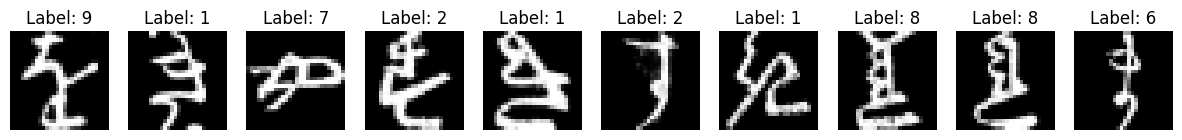

In [12]:
# Extract a few examples from the training set
num_examples = 10
train_data = train.take(num_examples)

# Display the images
fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))

for i, example in enumerate(train_data):
    image = example['image'].numpy().squeeze()  # Extract and reshape the image
    label = example['label'].numpy()
    
    # Display the image
    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')

plt.show()

Para efectos practicos, transformaremos la data en un array de numpy para realizar un estudio mas profundo del numero de datos y si se necesita una transformación adicional.

In [20]:
def to_narray(data):
    data_images = []
    data_labels = []

    for example in data:
        image = example['image'].numpy().squeeze()
        label = example['label'].numpy()
        
        data_images.append(image)
        data_labels.append(label)

    # Convert lists to NumPy arrays
    data_images = np.array(data_images)
    data_labels = np.array(data_labels)
    return data_images, data_labels


trainX, trainY = to_narray(train)
testX, testY = to_narray(test)

# Print the shapes of the NumPy arrays
print("Train images shape:", trainX.shape)
print("Train labels shape:", trainY.shape)
print("Test images shape:", testX.shape)
print("Test labels shape:", testY.shape)

Train images shape: (60000, 28, 28)
Train labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


Los conjuntos de labes (Y) deben ser llevados a un array de al menos dos dimensiones.

In [26]:
trainY = trainY.reshape(60000,1 )
testY = testY.reshape(10000, 1)

La data de label viene identificada con un número en el label, es necesario transformarlos a un vector de dimension (10,1) para poder clasificar correctamente.

In [27]:
trainY, testY = to_categorical(trainY), to_categorical(testY)
trainY.shape

(60000, 10)

In [28]:
testY

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

Veamos si la data esta normalizada

In [31]:
trainX[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,  21, 171, 161,  52,
          1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   6,   2,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  10,  31,  32, 137, 255, 255, 241,
        138,  63,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0, 119, 230, 240, 249, 255, 255, 255,
        245, 207,  14,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  64, 226, 255, 255, 255, 204,  84,
         51,  13,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  54, 164, 254, 240,  48,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  39, 251, 197,   2,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

Se debe normalizar

In [35]:
def normalize_data(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    
    return train_norm, test_norm
    
trainX, testX = normalize_data(trainX, testX)

Guardamos el conjunto de datos como un archico .npz para futuros estudios

In [36]:
np.savez('data/data.npz', trainX=trainX, trainY=trainY, testX=testX, testY=testY)

Realicemos un vistazo al modelo a utilizar:

In [39]:
lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 6)         156       
                                                                 
 average_pooling2d (Average  (None, 12, 12, 6)         0         
 Pooling2D)                                                      
                                                                 
 activation (Activation)     (None, 12, 12, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 activation_1 (Activation)   (None, 8, 8, 16)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 120)         48120     
                                                        

In [40]:
lenet_model.save("models/lenet_comp.h5")

c:\Users\angel\OneDrive\Documentos\RNN\Tarea 2 Soluciones\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
